Loading dataset...
Error loading dataset: Loading a dataset cached in a LocalFileSystem is not supported.
Creating dummy data instead...

Pretraining autoencoder...
Epoch [1/20], Loss: 0.0016
Epoch [2/20], Loss: 0.0006
Epoch [3/20], Loss: 0.0005
Epoch [4/20], Loss: 0.0005
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0005
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0003
Epoch [13/20], Loss: 0.0003
Epoch [14/20], Loss: 0.0003
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002

Performing clustering...
Silhouette Score: 0.2136
Davies-Bouldin Index: 1.5612

Visualizing clusters...


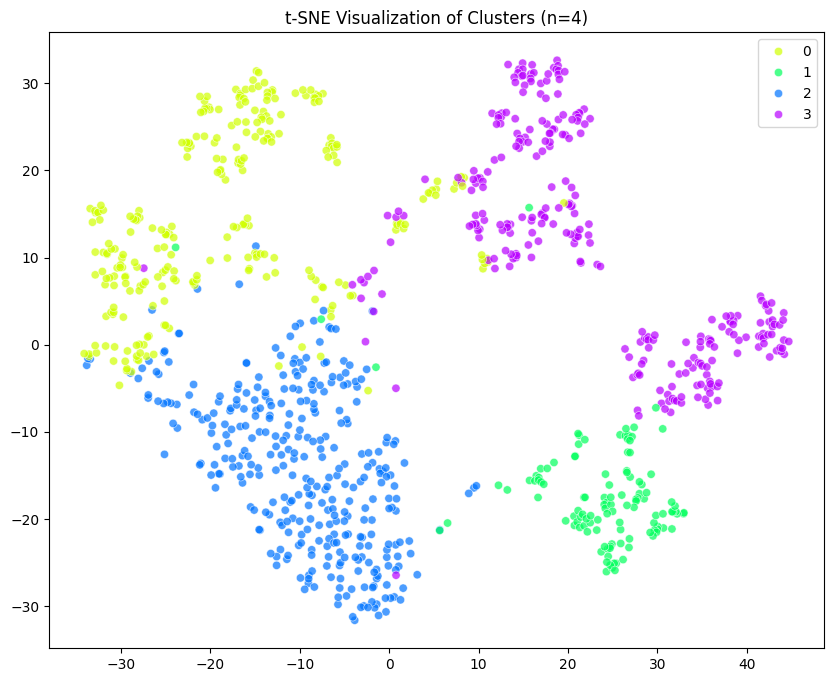


Fine-tuning with Deep Embedded Clustering...
DEC Epoch [1/10], Loss: 0.0007
DEC Epoch [2/10], Loss: 0.0000
DEC Epoch [3/10], Loss: 0.0000
DEC Epoch [4/10], Loss: 0.0000
DEC Epoch [5/10], Loss: 0.0000
DEC Epoch [6/10], Loss: 0.0000
DEC Epoch [7/10], Loss: 0.0000
DEC Epoch [8/10], Loss: 0.0000
DEC Epoch [9/10], Loss: 0.0000
DEC Epoch [10/10], Loss: 0.0000

Final Silhouette Score: 0.2239
Final Davies-Bouldin Index: 1.3365


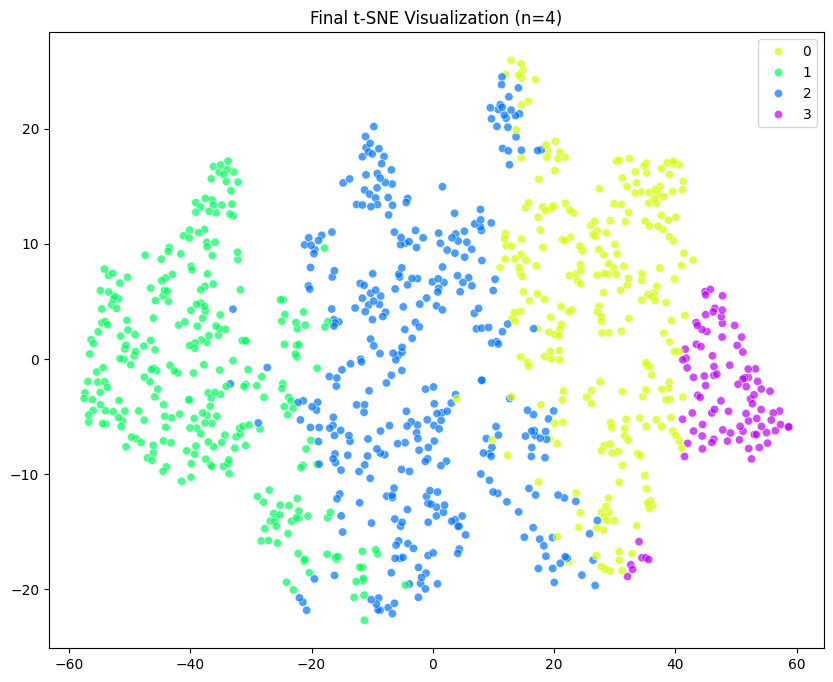

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration
DATASET_NAME = "fancyzhx/ag_news"
TEXT_DATA = True
N_CLUSTERS = 4
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 20
CACHE_DIR = "./dataset_cache"

os.makedirs(CACHE_DIR, exist_ok=True)

# 1. Load and preprocess data
print("Loading dataset...")
try:
    if TEXT_DATA:
        dataset = load_dataset(DATASET_NAME, cache_dir=CACHE_DIR)
        texts = dataset['train']['text'][:5000]

        print("Creating text embeddings...")
        embedder = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = embedder.encode(texts)
        features = torch.tensor(embeddings, dtype=torch.float32)
        input_size = embeddings.shape[1]
    else:
        dataset = load_dataset(DATASET_NAME, cache_dir=CACHE_DIR)
        images = np.array(dataset['train']['image'][:5000])
        labels = np.array(dataset['train']['label'][:5000]) if 'label' in dataset['train'].features else None
        images = images / 255.0
        if len(images.shape) == 3:
            images = np.expand_dims(images, axis=-1)
        features = torch.tensor(images.reshape(len(images), -1), dtype=torch.float32)
        input_size = images.shape[1] * images.shape[2] * (images.shape[3] if len(images.shape) > 3 else 1)

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Creating dummy data instead...")
    if TEXT_DATA:
        texts = [f"This is sample text {i}" for i in range(1000)]
        embedder = SentenceTransformer('all-MiniLM-L6-v2')
        embeddings = embedder.encode(texts)
        features = torch.tensor(embeddings, dtype=torch.float32)
        input_size = embeddings.shape[1]
    else:
        features = torch.randn(1000, 784)
        input_size = 784

# 2. Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 3. Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(input_size, LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = TensorDataset(features)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Train autoencoder
print("\nPretraining autoencoder...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)
        encoded, decoded = model(inputs)
        loss = criterion(decoded, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(dataloader):.4f}")

# 5. Extract latent
model.eval()
with torch.no_grad():
    latent_representations = model.encoder(features.to(device)).cpu().numpy()

# 6. Clustering
print("\nPerforming clustering...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(latent_representations)

# 7. Evaluation
silhouette = silhouette_score(latent_representations, cluster_labels)
db_index = davies_bouldin_score(latent_representations, cluster_labels)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

# 8. Visualize
print("\nVisualizing clusters...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(latent_representations)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=cluster_labels,
    palette=sns.color_palette("hsv", N_CLUSTERS),
    legend="full",
    alpha=0.7
)
plt.title(f"t-SNE Visualization of Clusters (n={N_CLUSTERS})")
plt.show()

# 9. DEC fine-tuning
def train_dec(model, dataloader, cluster_centers, device, epochs=10):
    model.train()
    alpha = 1.0
    cluster_centers = torch.tensor(cluster_centers, dtype=torch.float32).to(device)
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0].to(device)
            z = model.encoder(inputs)
            dist = torch.sum((z.unsqueeze(1) - cluster_centers)**2, dim=2)
            numerator = (1 + dist / alpha) ** (-(alpha + 1) / 2)
            denominator = torch.sum(numerator, dim=1, keepdim=True)
            q = numerator / denominator
            p = (q**2) / torch.sum(q, dim=0)
            p = p / torch.sum(p, dim=1, keepdim=True)
            loss = torch.mean(torch.sum(p * torch.log(p / (q + 1e-8)), dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"DEC Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

print("\nFine-tuning with Deep Embedded Clustering...")
initial_centers = kmeans.cluster_centers_
train_dec(model, dataloader, initial_centers, device, epochs=10)

# Final clustering and visualization
model.eval()
with torch.no_grad():
    final_representations = model.encoder(features.to(device)).cpu().numpy()

final_labels = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit_predict(final_representations)
final_silhouette = silhouette_score(final_representations, final_labels)
final_db = davies_bouldin_score(final_representations, final_labels)
print(f"\nFinal Silhouette Score: {final_silhouette:.4f}")
print(f"Final Davies-Bouldin Index: {final_db:.4f}")

final_embeddings_2d = tsne.fit_transform(final_representations)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=final_embeddings_2d[:, 0], y=final_embeddings_2d[:, 1],
    hue=final_labels,
    palette=sns.color_palette("hsv", N_CLUSTERS),
    legend="full",
    alpha=0.7
)
plt.title(f"Final t-SNE Visualization (n={N_CLUSTERS})")
plt.show()
